# Performance

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm
from src.simulation import *
from src.env import StockTradingEnv
from src.agent import DDPG_Hedger
from src.network import MLP

/Users/mac/Desktop/Repos/ml_project_2_deep_hedging/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate data and appply classical hedging

In [2]:
T = 60 # length of simulation 20=1 month, 60 = three months
S0 = 100 # starting price
K = 100 # strike price
sigma = 0.2 # volatility
r = 0 # risk-free rate
q = 0 # dividend yield
mu = 0.05 # expected return on stock
kappa = 0.01 # trading cost per unit traded
dt = 1 # hedging time step
notional = 100 # how many stocks the option is on
rho = -0.4 # correlation of stochastic volatility process
v = 0.6
sigma0 = 0.2 # starting volatility
c = 1.5 #standard deviation coefficient
ds = 0.01

n = 25000 # number of simulatied paths
days = 250 # number of days in a year
freq = 1 # trading frequency
np.random.seed(1)

- 1st run: save train data
- 2nd run or more: ignore this process and import data and run afterwards.

In [3]:
S_gbm, p_gbm, d_gbm = simulateGBM(n, T, dt, S0, mu, r, q, sigma, days, freq, K)

S_sabr, s_sabr, iv_sabr, p_sabr, delta_sabr, delta_sabr_bl = simulateSABR(
    n, T, dt, S0, mu, r, q, sigma, days, freq, rho, ds, v, K)

100%|██████████| 59/59 [00:00<00:00, 105.95it/s]
/Users/mac/Desktop/Repos/ml_project_2_deep_hedging/src/simulation.py:124: RuntimeWarning: invalid value encountered in divide
  imp_vol = np.where(f == K, atm, atm * xi / xi_func)


In [4]:
# classical hedging implementations (trading strategies)
trading_gbm, holding_gbm = hedgingStrategy("GBM",notional, d_gbm, 0)
trading_sabr, holding_sabr, trading_sabr_bl, holding_sabr_bl = hedgingStrategy("SABR",notional, delta_sabr, delta_sabr_bl)

In [5]:
# Accounting PnL
APL_gbm, holding_lagged_gbm = APL_process(S_gbm, p_gbm*notional, holding_gbm, K, notional, kappa)
APL_sabr, holding_lagged_sabr = APL_process(S_sabr, p_sabr*notional, holding_sabr, K, notional, kappa)
APL_sabr_bl, holding_lagged_sabr_bl = APL_process(S_sabr, p_sabr*notional, holding_sabr_bl, K, notional, kappa)

In [6]:
# Evaluation:
# Y(0) (take mean), 
# mean of  cost as percentage of option price,
# std of  cost as percentage of option price.

Y_gbm, mPerc_gbm, stdPerc_gbm = evaluate(APL_gbm, p_gbm, c, notional) 
Y_sabr, mPerc_sabr, stdPerc_sabr = evaluate(APL_sabr, p_sabr, c, notional)
Y_sabr_bl, mPerc_sabr_bl, stdPerc_sabr_bl = evaluate(APL_sabr_bl, p_sabr, c, notional)

In [7]:
print("GBM")
print("Y0: ", np.mean(Y_gbm))
print("mean cost (%): ", mPerc_gbm)
print("std cost (%): ", stdPerc_gbm)
print("\n")
print("SABR delta")
print("Y0: ", np.mean(Y_sabr))
print("mean cost (%): ", mPerc_sabr)
print("std cost (%): ", stdPerc_sabr)
print("\n")
print("SABR Bartlett")
print("Y0: ", np.mean(Y_sabr_bl))
print("mean cost (%): ", mPerc_sabr_bl)
print("std cost (%): ", stdPerc_sabr_bl)

GBM
Y0:  233.75656209909417
mean cost (%):  0.3118939779877127
std cost (%):  0.19091238252812498


SABR delta
Y0:  236.65688202375188
mean cost (%):  0.3114695347126298
std cost (%):  0.1961439481746562


SABR Bartlett
Y0:  237.37367164229065
mean cost (%):  0.31337575787764466
std cost (%):  0.1960961383585505


## data saving

In [56]:
result_folder_path = f"data/{T//20}month/{freq}d"
os.makedirs(result_folder_path, exist_ok=True)

# define data
# save to csv file
np.savetxt(f'data/{T//20}month/{freq}d/asset_price_GBM_sim.csv', S_gbm, delimiter=',')
np.savetxt(f'data/{T//20}month/{freq}d/option_price_GBM_sim.csv', p_gbm*notional, delimiter=',')
np.savetxt(f'data/{T//20}month/{freq}d/asset_price_SABR_sim.csv', S_sabr, delimiter=',')
np.savetxt(f'data/{T//20}month/{freq}d/option_price_SABR_sim.csv', p_sabr*notional, delimiter=',')


S_mixed = np.vstack((S_gbm, S_sabr))
p_mixed = np.vstack((p_gbm*notional, p_sabr*notional))
print(S_mixed.shape)
print(p_mixed.shape)
np.savetxt(f"data/{T//20}month/{freq}d/asset_price_mixed_sim.csv", S_mixed, delimiter=",")
np.savetxt(f"data/{T//20}month/{freq}d/option_price_mixed_sim.csv", p_mixed, delimiter=",")


(50000, 12)
(50000, 12)


# Deep RL Method 

In [8]:

env = StockTradingEnv(maturity=3, frequency=1, data_type="GBM", test_env=True)

# set same dataset as delta hedging
env.asset_price = S_gbm
env.option_price = p_gbm

nState, nAction = env.observation_space.shape[0], \
                    env.action_space.shape[0]  # 3, 1

# we use hidden layer size of 32, 64 as the author used.
actor = MLP(nState, 32, nAction, "Sigmoid")
qnet_1 = MLP(nState + nAction, 32, nAction, "")
qnet_2 = MLP(nState + nAction, 32, nAction, "")
agent = DDPG_Hedger(actor, qnet_1, qnet_2, 0, 0, 1, 32)
agent.load('v7')

RuntimeError: Error(s) in loading state_dict for MLP:
	Unexpected key(s) in state_dict: "model.7.weight", "model.7.bias", "model.0.bias", "model.3.bias", "model.6.bias". 
	size mismatch for model.0.weight: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([64, 4]).
	size mismatch for model.1.weight: copying a param with shape torch.Size([32, 4]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for model.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for model.3.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for model.4.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.6.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([1, 32]).

In [9]:
path_indice, rewards_path, action_path = [], [], []
for i in range(25000):
    state = env.reset()
    env.path_idx = i
    
    path_indice.append(env.path_idx)
    rewards, actions = [], [0]
    done = False
    
    if i%1000 == 0:
        print(f'Episode {i}')
    while not done:
        normalized_state = env.normalize(state)
        
        # action without exploration
        action = agent.act(normalized_state, 0)
        
        next_state, reward, done = env.step(action)

        state = next_state
        rewards.append(np.round(reward, 2))
        actions.append(np.round(action, 2)) # each episode [0.99, 13.20 ... 100 ] shape (1,60) 
         
        if done:
            break

    rewards_path.append(rewards) # <- (numEpisode=25000, 60)
    action_path.append(actions) # (numEpisode=25000, 60) = holding_gbm

Episode 0
Episode 1000
Episode 2000
Episode 3000
Episode 4000
Episode 5000
Episode 6000
Episode 7000
Episode 8000
Episode 9000
Episode 10000
Episode 11000
Episode 12000
Episode 13000
Episode 14000
Episode 15000
Episode 16000
Episode 17000
Episode 18000
Episode 19000
Episode 20000
Episode 21000
Episode 22000
Episode 23000
Episode 24000


In [10]:
# get action array as holding gbm
apl_gbm_rl, holding_lagged_rl = APL_process(S_gbm, p_gbm*notional, np.array(action_path), K, notional, kappa)

In [11]:
Y_gbm_rl, mPerc_gbm_rl, stdPerc_gbm_rl = evaluate(apl_gbm_rl, p_gbm, c, notional) 

In [12]:
print("GBM")
print("Y0: ", np.mean(Y_gbm))
print("mean cost (%): ", mPerc_gbm)
print("std cost (%): ", stdPerc_gbm)

print("GBM RL")
print("Y0: ", np.mean(Y_gbm_rl))
print("mean cost (%): ", mPerc_gbm_rl)
print("std cost (%): ", stdPerc_gbm_rl)

GBM
Y0:  233.75656209909417
mean cost (%):  0.3118939779877127
std cost (%):  0.19091238252812498
GBM RL
Y0:  1266.9395813089816
mean cost (%):  1.367338884819828
std cost (%):  1.2501269582588428


# Results

- add reward plots 
- episode total reward histograms (classic delta, RL agent)

In [ ]:
# ep 1 = 800, ep 2 = 67, ep 3 = -123 cumulative (up to 25000 episodes) 

# (25000, 2): 2 means classical delta and RL agent hedging.

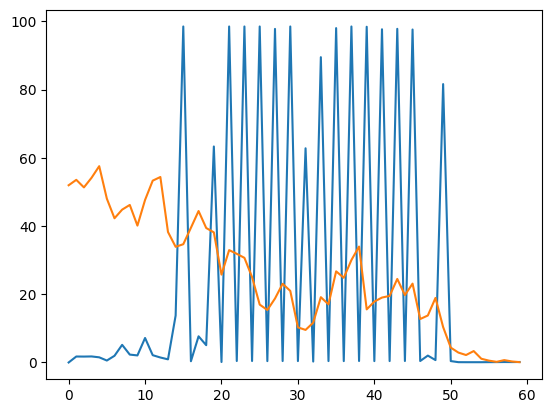

In [15]:
plt.plot(np.array(action_path)[50], label='RL delta')
plt.plot(holding_gbm[50], label='Classic delta')
plt.xlabel('')